In [ ]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
og_med_data = pd.read_json("hf://datasets/ncbi/Open-Patients/Open-Patients.jsonl", lines=True)
og_med_data.head()

,_id,description
0,trec-cds-2014-1,A 58-year-old African-American woman presents ...
1,trec-cds-2014-2,An 8-year-old male presents in March to the ER...
2,trec-cds-2014-3,A 58-year-old nonsmoker white female with mild...
3,trec-cds-2014-4,A 2-year-old boy is brought to the emergency d...
4,trec-cds-2014-5,A 56-year-old female on 20th day post-left mas...


In [5]:
og_med_data_subset = og_med_data.iloc[0:30000,:]

In [104]:
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract")
embedding_model = AutoModel.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract").to("cuda")

In [7]:
candidate_labels = [
    "Cardiac Conditions", "Infectious Diseases", "Respiratory Issues",
    "Neurological Disorders", "Post-Surgical Complications", "Skin Conditions",
    "Psychiatric/Mental Health", "Endocrine/Diabetes-Related Issues", "Other Issues"]

In [8]:
def classify_with_zero_shot(texts, classifier, labels, threshold=0.75):
    results = classifier(texts, labels, multi_label=False)
    
    processed_results = []
    for result in results:
        label = result["labels"][0]
        score = result["scores"][0]
        if score >= threshold:
            processed_results.append({"label": label, "score": score})
        else:
            processed_results.append({"label": None, "score": score})
    
    return processed_results

In [9]:
def generate_embeddings(texts, model, tokenizer, batch_size=16):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state
            batch_embeddings = torch.mean(hidden_states, dim=1)  
            embeddings.append(batch_embeddings)
            
    return torch.cat(embeddings)

In [10]:
def reduce_dims(embeddings, n_components=50):
    embeddings_np = embeddings.cpu().numpy()  

    max_components = min(embeddings_np.shape[0], embeddings_np.shape[1])
    if n_components > max_components:
        n_components = max_components

    pca = PCA(n_components=n_components, random_state=5624)
    reduced_embeddings_np = pca.fit_transform(embeddings_np)

    reduced_embeddings = torch.tensor(reduced_embeddings_np, device=embeddings.device)
    return reduced_embeddings

In [11]:
def perform_clustering(embeddings, num_clusters, n_components=50):
    if embeddings.shape[0] < num_clusters:
        num_clusters = embeddings.shape[0] 

    reduced_embeddings = reduce_dims(embeddings, n_components)

    reduced_embeddings_np = reduced_embeddings.cpu().numpy()
    kmeans = KMeans(n_clusters=num_clusters, random_state=5624)
    cluster_labels = kmeans.fit_predict(reduced_embeddings_np)

    return cluster_labels, kmeans

In [12]:
cluster_to_label = {
    5: "Post-Surgical Complications",
    4: "Neurological Disorders",
    2: "Psychiatric/Mental Health",
    6: "Skin Conditions",
    3: "Infectious Diseases",
    7: "Endocrine/Diabetes-Related Issues",
    1: "Cardiac Conditions",
    0: "Other Issues",
    8: "Respiratory Issues",
}

In [13]:
def hybrid_zero_shot_learning_pipeline(data, candidate_labels, zero_shot_classifier, embedding_model, tokenizer,
                                       n_clusters=9, threshold=0.75, batch_size=16, pca_components=50):
    high_confidence = []
    low_confidence = []

    texts = data["description"].tolist()
    zero_shot_results = classify_with_zero_shot(texts, zero_shot_classifier, candidate_labels, threshold)

    for i, res in enumerate(zero_shot_results):
        if res["label"]:
            high_confidence.append({"description": texts[i], "label": res["label"], "score": res["score"]})
        else:
            low_confidence.append({"description": texts[i]})

    low_conf_df = pd.DataFrame(low_confidence)
    if not low_conf_df.empty:
        low_conf_embeddings = generate_embeddings(low_conf_df["description"].tolist(), embedding_model, tokenizer, batch_size)
        cluster_labels, kmeans_model = perform_clustering(low_conf_embeddings, num_clusters=n_clusters, n_components=pca_components)
        low_conf_df["cluster_label"] = cluster_labels
        low_conf_df["final_label"] = low_conf_df["cluster_label"].map(cluster_to_label)
        low_conf_df["score"] = None  

    high_conf_df = pd.DataFrame(high_confidence)
    high_conf_df["final_label"] = high_conf_df["label"]
    high_conf_df["cluster_label"] = None 

    labelled_data = pd.concat(
        [high_conf_df[["description", "final_label", "score", "cluster_label"]],
         low_conf_df[["description", "final_label", "score", "cluster_label"]]],
        ignore_index=True
    )

    return high_conf_df, low_conf_df, labelled_data

In [14]:
high_conf_df, low_conf_df, final_df = hybrid_zero_shot_learning_pipeline(og_med_data_subset, candidate_labels, zero_shot_classifier, embedding_model, tokenizer, n_clusters=9, threshold=0.75, batch_size=16)

In [15]:
print(final_df[['description', 'final_label']].tail(10))

                                            description  \
9990  A 52-year-old female with no past medical or s...   
9991  A 37-year old female presented to the neurolog...   
9992  A 74-year-old male patient applied to the emer...   
9993  In 2006, a 38-year-old man was ejected from th...   
9994  A 43-year-old African American male was referr...   
9995  A 21-year-old male with a history of one episo...   
9996  A 33-year-old man ruptured his left Achilles t...   
9997  The patient was a 9-year-old boy with a histor...   
9998  A 16-year-old male with unremarkable past medi...   
9999  A 66-year-old gentleman with no known comorbid...   

                    final_label  
9990         Cardiac Conditions  
9991     Neurological Disorders  
9992               Other Issues  
9993  Psychiatric/Mental Health  
9994     Neurological Disorders  
9995            Skin Conditions  
9996        Infectious Diseases  
9997        Infectious Diseases  
9998            Skin Conditions  
9999     N

In [16]:
print(final_df.head(10))

                                         description         final_label  \
0  An 8-year-old male presents in March to the ER...  Respiratory Issues   
1  A 58-year-old nonsmoker white female with mild...  Respiratory Issues   
2  A 62 yo male presents with four days of non-pr...  Respiratory Issues   
3  A 65 yo African-American male with shortness o...  Respiratory Issues   
4  A 66yo female with significant smoking history...  Respiratory Issues   
5  A 31 yo male with no significant past medical ...  Respiratory Issues   
6  A 52 year-old woman with chronic obstructive p...  Respiratory Issues   
7  This is a 54 year old male patient with an idi...  Respiratory Issues   
8  A 39-year-old man came to the clinic with coug...  Respiratory Issues   
9  A 57-year-old man was admitted to the clinic b...  Respiratory Issues   

      score cluster_label  
0  0.880696          None  
1  0.813393          None  
2  0.851462          None  
3  0.835472          None  
4  0.911800          No

In [17]:
#final_df.to_csv('final_df.csv')

In [126]:
# final_df = pd.read_csv('final_df.csv')

In [127]:
final_df.head()

,Unnamed: 0,description,final_label,score,cluster_label
0,0,An 8-year-old male presents in March to the ER...,Respiratory Issues,0.880696,NaN
1,1,A 58-year-old nonsmoker white female with mild...,Respiratory Issues,0.813393,NaN
2,2,A 62 yo male presents with four days of non-pr...,Respiratory Issues,0.851462,NaN
3,3,A 65 yo African-American male with shortness o...,Respiratory Issues,0.835472,NaN
4,4,A 66yo female with significant smoking history...,Respiratory Issues,0.911800,NaN


In [128]:
final_df.isnull().sum()

Unnamed: 0          0
description         0
final_label         0
score            9946
cluster_label      54
dtype: int64

In [129]:
final_df = final_df[['description', 'final_label']]

In [130]:
final_df.head()

,description,final_label
0,An 8-year-old male presents in March to the ER...,Respiratory Issues
1,A 58-year-old nonsmoker white female with mild...,Respiratory Issues
2,A 62 yo male presents with four days of non-pr...,Respiratory Issues
3,A 65 yo African-American male with shortness o...,Respiratory Issues
4,A 66yo female with significant smoking history...,Respiratory Issues


In [131]:
def remove_first_sentence(text):
    sentences = text.split(".")
    if len(sentences) > 1:
        return ". ".join(sentences[1:])
    return text

In [132]:
final_df["modified_description"] = final_df["description"].apply(remove_first_sentence)

In [133]:
final_df[['modified_description', 'final_label']].head(10)

,modified_description,final_label
0,He has just returned from a 5 day vacation in...,Respiratory Issues
1,She is otherwise asymptomatic. A neurologic ...,Respiratory Issues
2,"He is on immunosuppressive medications, inclu...",Respiratory Issues
3,He also has difficulty breathing when lying f...,Respiratory Issues
4,She is in moderate respiratory distress after...,Respiratory Issues
5,He reports developing cold symptoms one week ...,Respiratory Issues
6,Had been seen by primary care provider for t...,Respiratory Issues
7,He had been in unusual state of good health a...,Respiratory Issues
8,He had these symptoms for 5 days during the p...,Respiratory Issues
9,Chest computed topography showed bilateral mu...,Respiratory Issues


In [134]:
def replace_pronouns(text):
    pronoun_patterns = [
        (r'\b(he|she|they|it)\b', 'The person'),
        (r'\b(his|her|their|its)\b', 'The person\'s'),
        (r'\b(him|her|them)\b', 'The person')
    ]

    for pattern, replacement in pronoun_patterns:
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    return text

In [135]:
final_df["modified_description"] = final_df["modified_description"].apply(replace_pronouns)

In [136]:
final_df[['modified_description', 'final_label']].head(10)

,modified_description,final_label
0,The person has just returned from a 5 day vac...,Respiratory Issues
1,The person is otherwise asymptomatic. A neur...,Respiratory Issues
2,The person is on immunosuppressive medication...,Respiratory Issues
3,The person also has difficulty breathing when...,Respiratory Issues
4,The person is in moderate respiratory distres...,Respiratory Issues
5,The person reports developing cold symptoms o...,Respiratory Issues
6,Had been seen by primary care provider for t...,Respiratory Issues
7,The person had been in unusual state of good ...,Respiratory Issues
8,The person had these symptoms for 5 days duri...,Respiratory Issues
9,Chest computed topography showed bilateral mu...,Respiratory Issues


In [137]:
def group_by_label_and_concatenate(df, label_column='final_label', text_column='description'):
    grouped = (df.groupby(label_column)[text_column].apply(lambda x: ' '.join(x.astype(str))).reset_index().rename(columns={text_column: 'grouped_text'}))
    
    return grouped

In [138]:
grouped_notes = group_by_label_and_concatenate(final_df, label_column='final_label', text_column='modified_description')

In [139]:
grouped_notes.head(10)

,final_label,grouped_text
0,Cardiac Conditions,"On examination, multiple lesions are seen. ..."
1,Endocrine/Diabetes-Related Issues,The person was treated conservatively for 20 ...
2,Infectious Diseases,\nThe patient presented at the ER with a 3-wee...
3,Neurological Disorders,The localization of headache was mainly on le...
4,Other Issues,"The patient had hypertension, renal-artery st..."
5,Post-Surgical Complications,The person had a total hysterectomy and was s...
6,Psychiatric/Mental Health,The patient reported being exposed directly t...
7,Respiratory Issues,The person has just returned from a 5 day vac...
8,Skin Conditions,The rashes are mildly itchy. The patient ha...


In [140]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
    print("Torch CUDA Version:", torch.version.cuda)
    print("Torch Version:", torch.__version__)
else:
    print("CUDA is not available.")

Is CUDA available: True
Device Name: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA Version: 12.4
Torch CUDA Version: 12.4
Torch Version: 2.5.1+cu124


In [141]:
torch.cuda.empty_cache()

In [142]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract")
model = AutoModel.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract").to("cuda")

In [143]:
def generate_sentence_embeddings(sentences, tokenizer, model, batch_size=4):
    embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch_texts = sentences[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings)

In [144]:
def compute_mmr(doc_embedding, sentence_embeddings, sentences, top_n=3, lambda_param=0.85):
    selected_sentences = []
    selected_indices = []
    candidate_indices = list(range(len(sentences)))
    relevance_scores = []
    diversity_scores = []
    
    for _ in range(top_n):
        mmr_scores = []
        for i in candidate_indices:
            rel = cosine_similarity([doc_embedding.cpu().numpy()], [sentence_embeddings[i].cpu().numpy()])[0][0]
            div = max([
                cosine_similarity([sentence_embeddings[i].cpu().numpy()], [sentence_embeddings[j].cpu().numpy()])[0][0]
                for j in selected_indices
            ] or [0])
            
            mmr = lambda_param * rel - (1 - lambda_param) * div
            mmr_scores.append(mmr)
        
        selected_index = candidate_indices[np.argmax(mmr_scores)]
        selected_sentences.append(sentences[selected_index])
        selected_indices.append(selected_index)
        candidate_indices.remove(selected_index)
        relevance_scores.append(mmr_scores[np.argmax(mmr_scores)])
        diversity_scores.append(div)
    
    return selected_sentences, relevance_scores, diversity_scores


In [145]:
def extractive_summarization_with_metrics(grouped_notes, text_column, top_n=3, lambda_param=0.85, batch_size=4):
    summaries = []
    relevance_list = []
    diversity_list = []
    mmr_list = []
    
    for idx, row in grouped_notes.iterrows():
        sentences = row[text_column].split(". ")
        
        # Batch process embeddings
        doc_embedding = generate_sentence_embeddings([" ".join(sentences)], tokenizer, model, batch_size=batch_size)[0]
        sentence_embeddings = generate_sentence_embeddings(sentences, tokenizer, model, batch_size=batch_size)
        
        selected_sentences, relevance_scores, diversity_scores = compute_mmr(
            doc_embedding, sentence_embeddings, sentences, top_n=top_n, lambda_param=lambda_param
        )
        
        summaries.append(". ".join(selected_sentences))
        relevance_list.append(np.mean(relevance_scores))
        diversity_list.append(np.mean(diversity_scores))
        mmr_list.append(np.mean(relevance_scores) - np.mean(diversity_scores))
    
    grouped_notes["extractive_summary"] = summaries
    grouped_notes["relevance"] = relevance_list
    grouped_notes["diversity"] = diversity_list
    grouped_notes["mmr"] = mmr_list
    
    return grouped_notes

In [146]:
grouped_notes_with_extractive = extractive_summarization_with_metrics(
    grouped_notes, text_column="grouped_text", top_n=3, lambda_param=0.85, batch_size=4)

In [154]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

In [155]:
grouped_notes_with_extractive["extractive_cleaned"] = grouped_notes_with_extractive["extractive_summary"].apply(preprocess_text)

In [156]:
print(grouped_notes_with_extractive[['final_label', 'extractive_cleaned', 'relevance', 'diversity', 'mmr']].head(10))

                         final_label  \
0                 Cardiac Conditions   
1  Endocrine/Diabetes-Related Issues   
2                Infectious Diseases   
3             Neurological Disorders   
4                       Other Issues   
5        Post-Surgical Complications   
6          Psychiatric/Mental Health   
7                 Respiratory Issues   
8                    Skin Conditions   

                                  extractive_cleaned  relevance  diversity  \
0   the person denied having fever spikes and on ...   0.734872   0.627412   
1   papillary thyroid cancer dx w right neck mass...   0.736672   0.483604   
2   while being on active waiting list for kidney...   0.739921   0.629245   
3   the patient was severely dehydrated thyroid g...   0.738828   0.627022   
4   foci of increased tracer uptake were noted in...   0.737954   0.494882   
5   however in this case the poor osseointegratio...   0.737590   0.631152   
6   the person had no psychiatric problems for th... 

In [158]:
def plot_metrics(grouped_notes):
    metrics = ['relevance', 'diversity', 'mmr']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.bar(grouped_notes['final_label'], grouped_notes[metric], color='skyblue')
        plt.title(f"{metric.capitalize()} by Final Label")
        plt.xlabel("Final Label")
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

In [159]:
def generate_wordclouds(grouped_notes):
    for _, row in grouped_notes.iterrows():
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(row['extractive_cleaned'])
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for {row['final_label']}")
        plt.show()

In [160]:
def compare_lengths(grouped_notes, original_column, summary_column):
    grouped_notes['original_length'] = grouped_notes[original_column].apply(len)
    grouped_notes['summary_length'] = grouped_notes[summary_column].apply(len)
    grouped_notes['length_ratio'] = grouped_notes['summary_length'] / grouped_notes['original_length']

    plt.figure(figsize=(10, 6))
    plt.bar(grouped_notes['final_label'], grouped_notes['length_ratio'], color='purple')
    plt.title("Summary Length to Original Length Ratio by Final Label")
    plt.xlabel("Final Label")
    plt.ylabel("Length Ratio")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

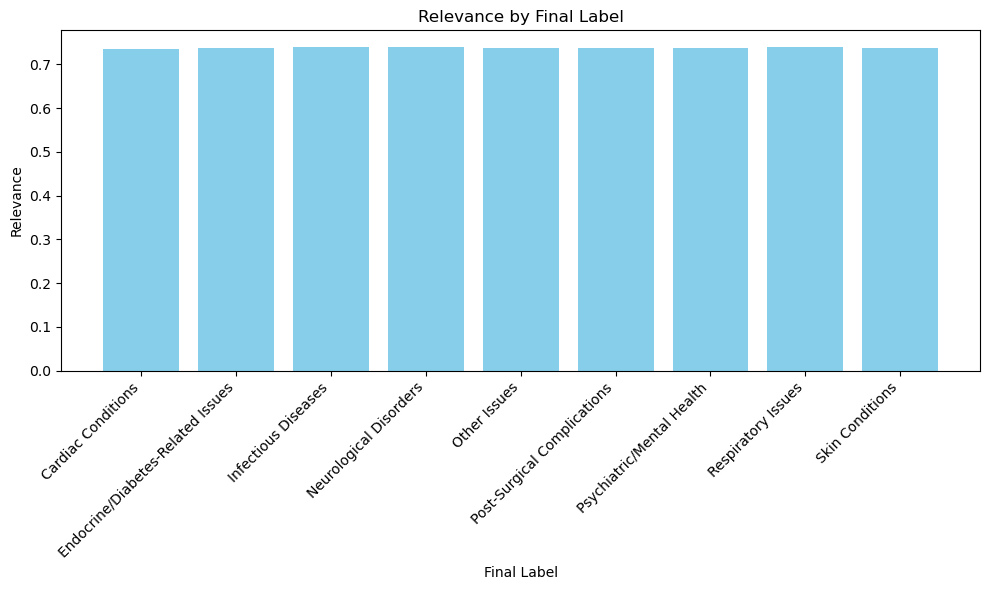

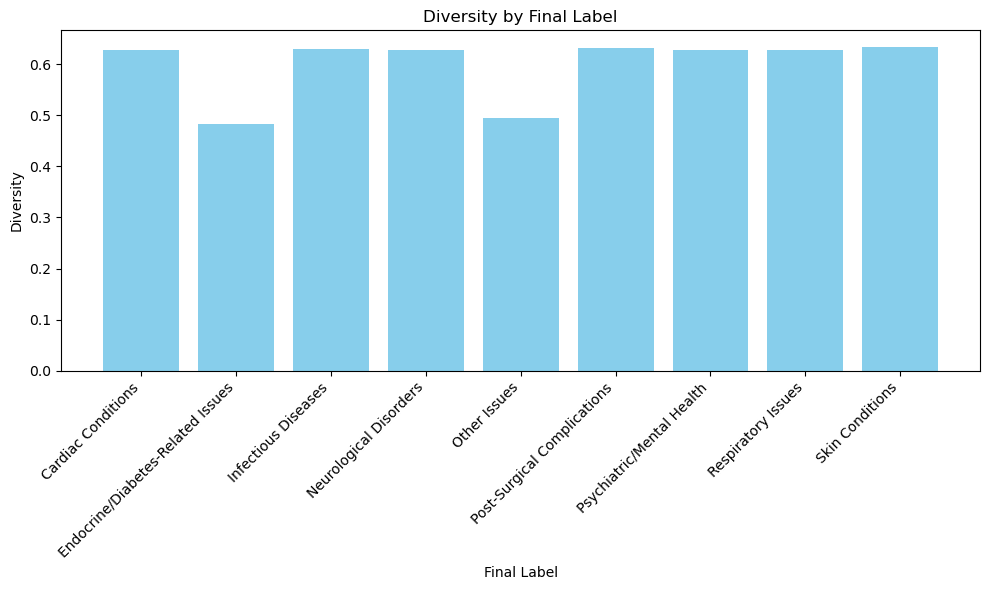

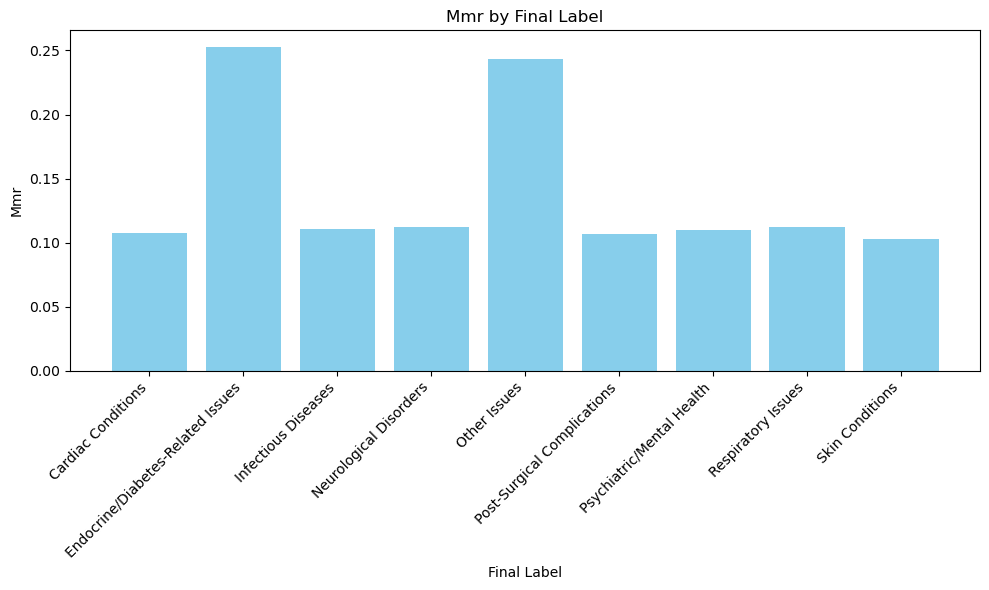

In [161]:
plot_metrics(grouped_notes_with_extractive)

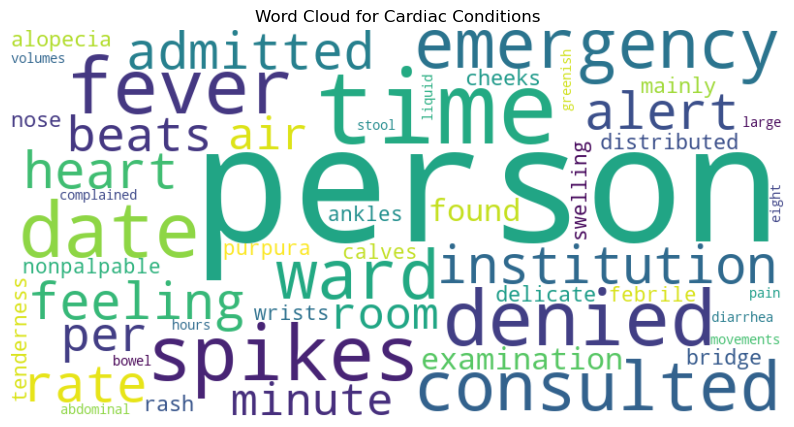

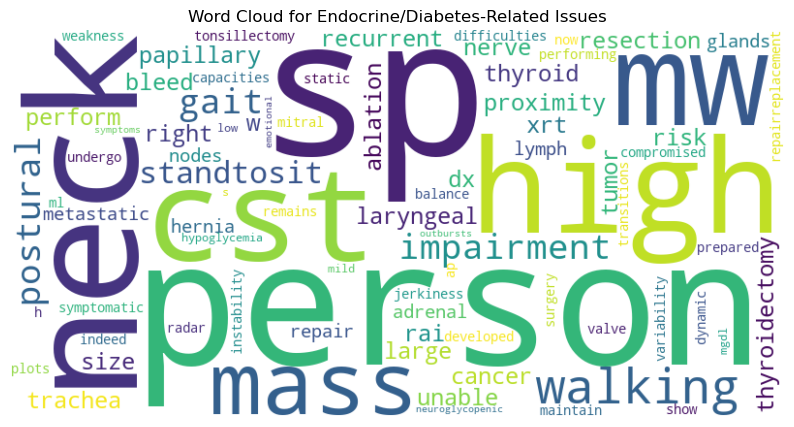

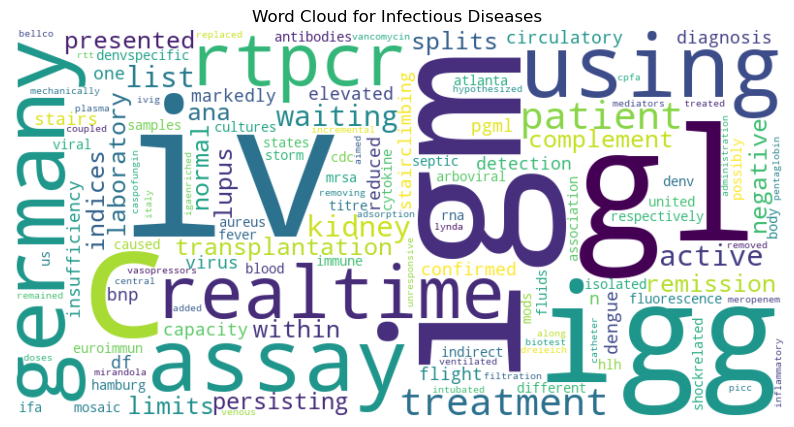

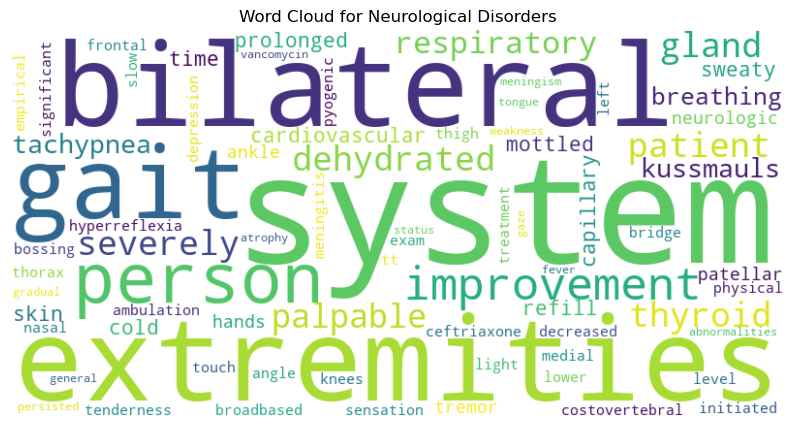

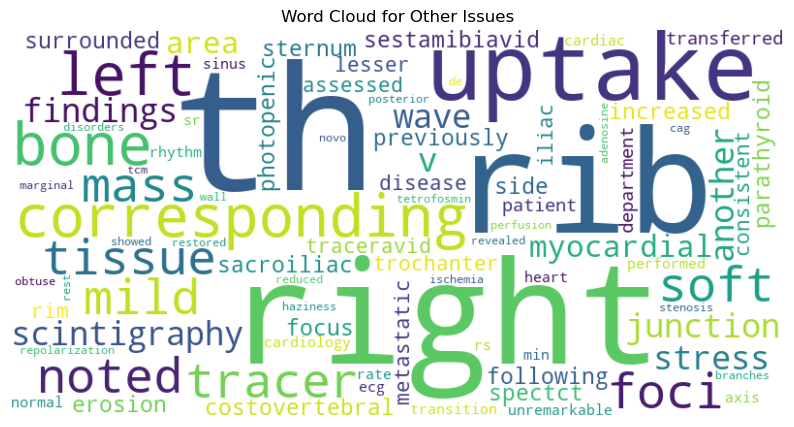

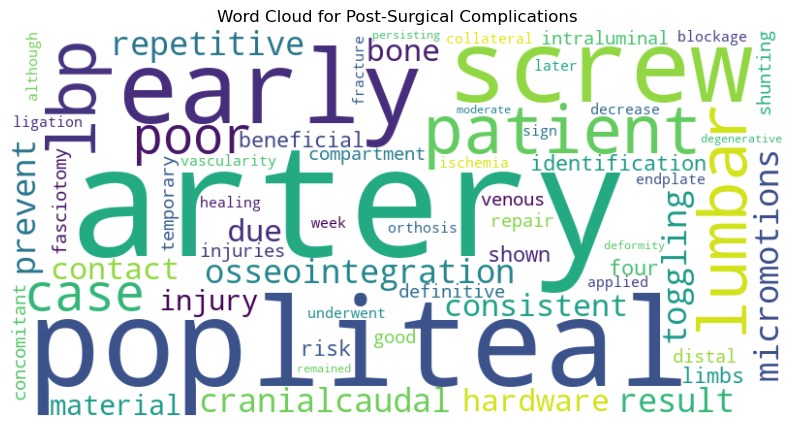

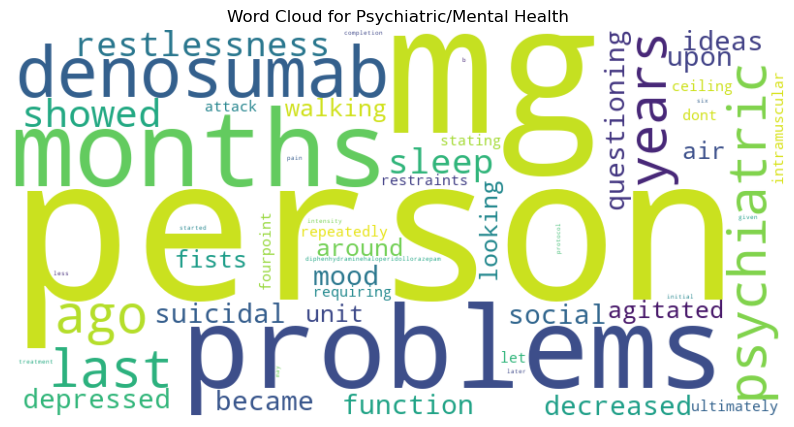

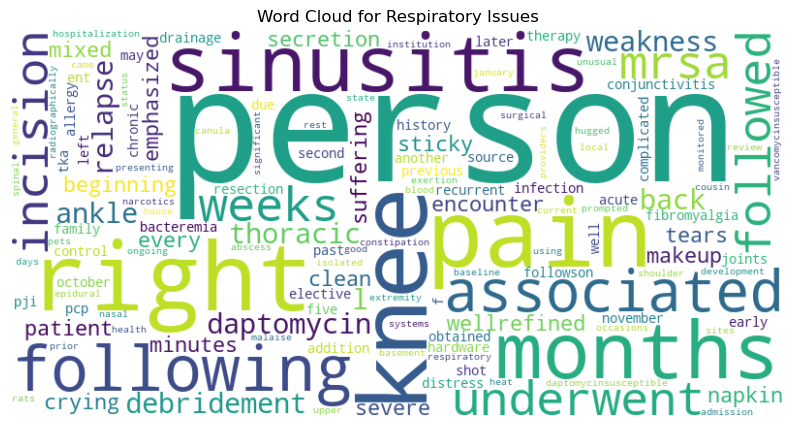

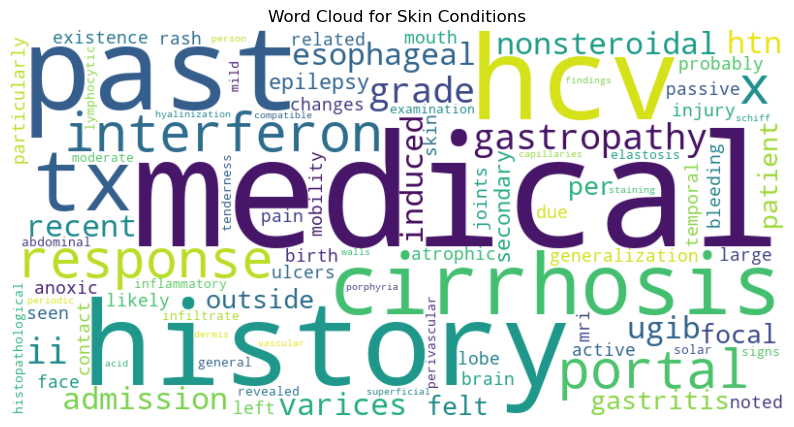

In [162]:
generate_wordclouds(grouped_notes_with_extractive)

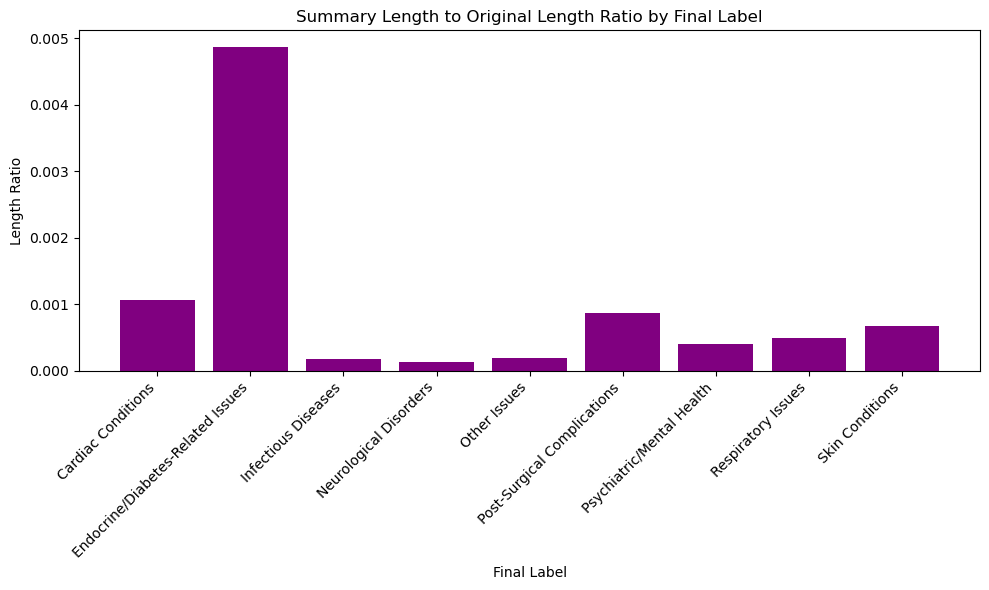

In [163]:
compare_lengths(grouped_notes_with_extractive, 'grouped_text', 'extractive_cleaned')